## Part 2. Model Training & Evaluation - RNN

Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from Part
0, you need to train a deep learning model for topic classification using the training set, conforming
to these requirements:
- Use the pretrained word embeddings from Part 1 as inputs, together with your implementation
in mitigating the influence of OOV words; make them learnable parameters during training
(they are updated).
- Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a topic label for each sentence. To do that, you need to consider how to aggregate
the word representations to represent a sentence.
- Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation.
- Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs.
- Try different regularization techniques to mitigate overfitting.
- Evaluate your trained model on the test dataset, observing the accuracy score.

In [1]:
import types
import json
import numpy as np
import torch
import random
import os
import lightning as L
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from torchtext import data, datasets
from utils.config import Config
from utils.train import train_rnn_model_with_parameters
from utils.helper import SentenceDataset, collate_fn
from models.RNN import RNN, RNNClassifier
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from utils.analytics import load_tensorboard_logs, test_top_n_models
from sklearn.metrics import classification_report


/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths=True)
LABEL = data.LabelField()

train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

train_data, valid_data = train_data.split(random_state=random.seed(Config.SEED), split_ratio=0.8)

TEXT.build_vocab(train_data, vectors="glove.6B.300d")
LABEL.build_vocab(train_data)

### Import the embedding matrix and vocab index mapping (train data)

In [3]:
embedding_path = Path("models/embedding_matrix.npy")
index_from_word_path = Path("models/index_from_word.json")

embedding_matrix = np.load(embedding_path)
with index_from_word_path.open() as f:
    index_from_word = json.load(f)

### Dataset

In [4]:
train_dataset = SentenceDataset(train_data.examples, index_from_word, LABEL.vocab)
valid_dataset = SentenceDataset(valid_data.examples, index_from_word, LABEL.vocab)
test_dataset = SentenceDataset(test_data.examples, index_from_word, LABEL.vocab)        

In [5]:
num_workers = os.cpu_count() // 2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    multiprocessing_context='spawn',
    persistent_workers=True,
)

valid_dataloader = DataLoader(
    valid_dataset,  
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    multiprocessing_context='spawn',
    persistent_workers=True,
)

test_dataloader = DataLoader(  
    test_dataset,  
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    multiprocessing_context='spawn',
    persistent_workers=True,
)

L.seed_everything(Config.SEED)

callbacks = [
    ModelCheckpoint(
        monitor="val_loss",
        save_top_k=1,
        mode="min",
    ),
]

results = {}

Seed set to 42


In [18]:
train_results_df = load_tensorboard_logs(log_dir="tb_logs/rnn")

### Train RNN Model

In [6]:
SEARCH_SPACE = {
    "batch_size": [32, 64, 128],
    "optimizer_name": ["RMSprop", "Adam"],
    "learning_rate": [5e-4, 1e-3, 5e-3, 1e-2],  # More reasonable range
    "hidden_dim": [32, 64, 128, 256],
    "num_layers": [1, 2, 4],
    "sentence_representation_type": ["last", "average", "max"],
}

In [ ]:
for hidden_dim in SEARCH_SPACE["hidden_dim"]:
    for num_layers in SEARCH_SPACE["num_layers"]:
        for optimizer_name in SEARCH_SPACE["optimizer_name"]:
            for batch_size in SEARCH_SPACE["batch_size"]:
                for learning_rate in SEARCH_SPACE["learning_rate"]:
                    for sentence_representation_type in SEARCH_SPACE["sentence_representation_type"]:
                        log_message = f"---------- batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim}; num_layers_{num_layers}; sentence_representation_{sentence_representation_type}  ----------"
                        print(log_message)
                        train_rnn_model_with_parameters(
                            embedding_matrix=embedding_matrix,
                            train_dataset=train_dataset,
                            val_dataset=valid_dataset,
                            batch_size=batch_size,
                            learning_rate=learning_rate,
                            optimizer_name=optimizer_name,
                            hidden_dim=hidden_dim,
                            num_layers=num_layers,
                            sentence_representation_type=sentence_representation_type,
                            show_progress=True,
                            freeze_embedding=False,
                        )

### Model Configuration Comparison

In [20]:
train_results_df = train_results_df.sort_values(
    by=["val_acc"], ascending=False
).reset_index(drop=True)
train_results_df.head(20)

,val_acc,batch_size,hidden_dim,learning_rate,optimizer_name,train_loss,train_acc,num_layers,sentence_representation_type,freeze,epoch,val_loss,filename
0,0.880561,64,128,0.0010,RMSprop,0.000887,1.000000,2,max,False,12.0,0.386627,events.out.tfevents.1762318236.TC1N02.902847.89
1,0.878000,32,128,0.0005,RMSprop,0.000153,1.000000,2,max,False,13.0,0.402284,events.out.tfevents.1762316824.TC1N02.902847.74
2,0.877362,32,128,0.0010,Adam,0.000167,1.000000,2,max,False,12.0,0.421286,events.out.tfevents.1762320358.TC1N02.902847.113
3,0.877323,32,256,0.0010,Adam,0.010716,1.000000,1,average,False,12.0,0.544941,events.out.tfevents.1762311582.ArchThinkpadT14...
4,0.876144,32,128,0.0010,RMSprop,0.018316,1.000000,1,max,False,6.0,0.386054,events.out.tfevents.1762310388.TC1N02.902847.5
5,0.868879,32,128,0.0005,RMSprop,0.007183,1.000000,4,max,False,14.0,0.443699,events.out.tfevents.1762323326.TC1N02.902847.146
6,0.866854,64,128,0.0050,Adam,0.000179,1.000000,1,max,False,10.0,0.444732,events.out.tfevents.1762315152.TC1N02.902847.56
7,0.864732,32,256,0.0010,Adam,0.000051,1.000000,2,max,False,9.0,0.468953,events.out.tfevents.1762317671.ArchThinkpadT14...
8,0.862658,32,128,0.0050,RMSprop,0.009256,1.000000,1,max,False,6.0,0.504259,events.out.tfevents.1762310666.TC1N02.902847.8
9,0.862618,32,128,0.0005,Adam,0.017006,1.000000,2,average,False,8.0,0.513370,events.out.tfevents.1762319982.TC1N02.902847.109


### a) Report the final configuration of your best model, namely the number of training epochs, learning rate, optimizer, batch size and hidden dimension.

In [66]:
train_results_df.head(1)

,val_acc,batch_size,hidden_dim,learning_rate,optimizer_name,train_loss,train_acc,num_layers,sentence_representation_type,freeze,epoch,val_loss,filename
0,0.880561,64,128,0.001,RMSprop,0.000887,1.0,2,max,False,12.0,0.386627,events.out.tfevents.1762318236.TC1N02.902847.89


Answer: The final configuration for the best model is: Optimizer: RMSprop, Learning Rate: 0.001, Batch Size: 64, Hidden Dimension: 128, and Training Epochs: 12. This configuration was found by searching a space that intentionally excluded SGD and Adagrad to focus computational resources on more robust, modern adaptive optimizers. Standard SGD was likely omitted because it often converges much slower and is more sensitive to learning rate tuning, while Adagrad was excluded because its learning rate can decay too aggressively and prematurely stop the model from learning. The search was therefore limited to RMSprop and Adam, which are generally more effective as they fix Adagrad's specific flaws and typically provide faster, more reliable convergence for deep learning tasks.

### b) Report all the regularization strategies you have tried. Compare the accuracy on the test set among all strategies and the one without any regularization

### Without Regularization

In [6]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No L2 regularization
    show_progress=True
)

/Users/anthonychua/Desktop/Y3S1/SC4002 Natural Language Processing/SC4002/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'rnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rnn_model'])`.


In [7]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 69/69 [00:05<00:00, 12.47it/s, v_num=15, train_loss=0.000211, train_acc=1.000, val_loss=0.940, val_acc=0.818]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 69/69 [00:05<00:00, 12.46it/s, v_num=15, train_loss=0.000211, train_acc=1.000, val_loss=0.940, val_acc=0.818]


In [8]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['No Regularization'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 31.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.776709794998169     │
│         test_loss         │    1.0964425802230835     │
└───────────────────────────┴───────────────────────────┘

### Early Stopping only

In [9]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

In [10]:
es_callbacks = [ 
             EarlyStopping(monitor="val_acc",
                           mode="max",
                           patience=3,
                           min_delta=1e-4, ),
             ModelCheckpoint(monitor="val_loss",
                             save_top_k=1,
                             mode="min",
                             ),
             ]

trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=es_callbacks,   #Early stopping and model checkpointing
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 69/69 [00:04<00:00, 14.26it/s, v_num=16, train_loss=0.657, train_acc=0.917, val_loss=1.180, val_acc=0.654]  


In [11]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['Early Stopping'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 45.17it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5856718420982361     │
│         test_loss         │     1.428810715675354     │
└───────────────────────────┴───────────────────────────┘

### Dropout only


In [12]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.3,              #Dropout Added
    embedding_dropout=0.2,    #Dropout Added
    fc_dropout=0.3            #Dropout Added
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

In [13]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/anthonychua/Desktop/Y3S1/SC4002 Natural Language Processing/SC4002/venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/anthonychua/Desktop/Y3S1/SC4002 Natural Language Processing/SC4002/lightning_logs/version_15/checkpoints exists and is not empty.

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9

Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 14.87it/s, v_num=17, train_loss=0.000699, train_acc=1.000, val_loss=1.050, val_acc=0.807]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 14.87it/s, v_num=17, train_loss=0.000699, train_acc=1.000, val_loss=1.050, val_acc=0.807]


In [14]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['Dropout'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 37.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7848080396652222     │
│         test_loss         │    1.0960952043533325     │
└───────────────────────────┴───────────────────────────┘

### Gradient Clipping Only

In [15]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

In [16]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=1.0     #Gradient Clipping Added
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 14.42it/s, v_num=18, train_loss=1.37e-6, train_acc=1.000, val_loss=0.907, val_acc=0.851] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 14.42it/s, v_num=18, train_loss=1.37e-6, train_acc=1.000, val_loss=0.907, val_acc=0.851]


In [17]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['Gradient Clipping'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 35.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8493179082870483     │
│         test_loss         │    0.6804563403129578     │
└───────────────────────────┴───────────────────────────┘

### Weight Decay only

In [18]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=1e-7,  #Weight Decay Added
    show_progress=True
)

In [19]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 13.88it/s, v_num=19, train_loss=1.39e-5, train_acc=1.000, val_loss=0.742, val_acc=0.833] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 13.87it/s, v_num=19, train_loss=1.39e-5, train_acc=1.000, val_loss=0.742, val_acc=0.833]


In [20]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['Weight Decay'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 36.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8364062309265137     │
│         test_loss         │     0.65081787109375      │
└───────────────────────────┴───────────────────────────┘

### L2 Regularization Penalty only

In [26]:
def add_explicit_l2(model, l2_lambda=1e-4, exclude_bias=True, exclude_embed=True):
    import torch.nn.functional as F
    orig_step = model.training_step

    def _compute_l2_penalty(m):
        pen = torch.tensor(0., device=next(m.parameters()).device)
        for name, p in m.named_parameters():
            if not p.requires_grad:
                continue
            if exclude_bias and name.endswith(".bias"):
                continue
            if exclude_embed and "embedding" in name:
                continue
            pen += p.pow(2).sum()
        return pen

    def training_step_with_l2(self, batch, batch_idx):
        base_loss = orig_step(batch, batch_idx)
        l2 = _compute_l2_penalty(self)
        return base_loss + l2_lambda * l2

    model.training_step = types.MethodType(training_step_with_l2, model)
    return model  

In [27]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

In [28]:
model = add_explicit_l2(model, l2_lambda=1e-4, exclude_bias=True, exclude_embed=True)

trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 14.31it/s, v_num=21, train_loss=0.00344, train_acc=1.000, val_loss=0.697, val_acc=0.841] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 14.31it/s, v_num=21, train_loss=0.00344, train_acc=1.000, val_loss=0.697, val_acc=0.841]


In [29]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['L2 regularization'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 33.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8478491306304932     │
│         test_loss         │    0.5827051997184753     │
└───────────────────────────┴───────────────────────────┘

### Single Strategy Regularization comparison 

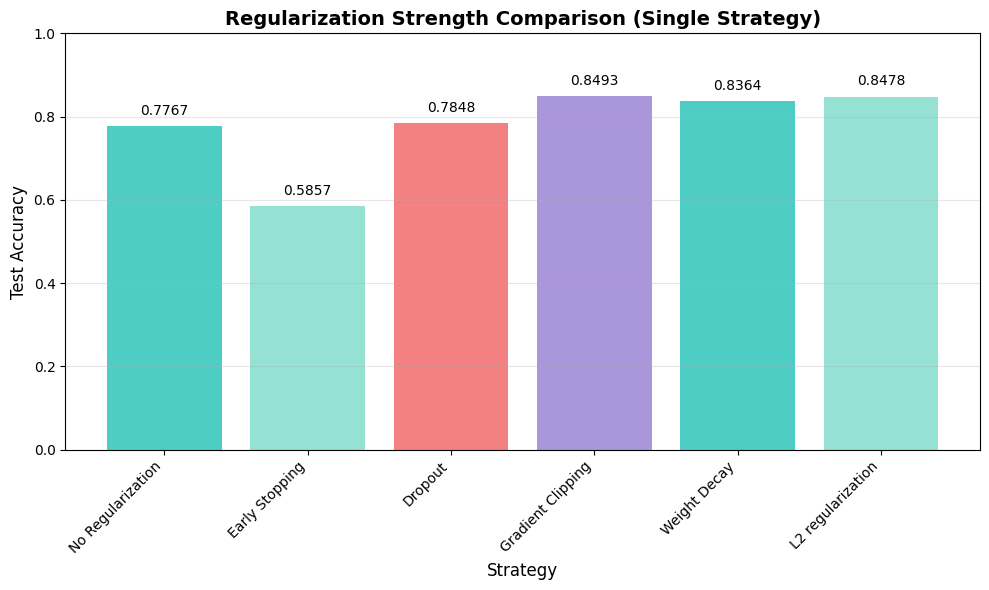

In [30]:
plt.figure(figsize=(10, 6))
strategies = list(results.keys())
accuracies = list(results.values())

plt.bar(strategies, accuracies, color=['#4ECDC4', '#95E1D3', '#F38181', '#AA96DA'])
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Regularization Strength Comparison (Single Strategy)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

for i, (strategy, acc) in enumerate(zip(strategies, accuracies)):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Single-Strategy Regularization

The baseline model (0.7767) demonstrates moderate performance but shows mild overfitting, indicating the need for regularization.

Individually applied regularizers produce varying effects on generalization and convergence stability:

- Early Stopping (0.5857) performs the worst, suggesting the model was halted prematurely before it could learn sufficiently rich representations, leading to severe underfitting.

- Dropout (0.7848) offers a small improvement over the baseline but remains limited, as excessive neuron deactivation in a relatively shallow RNN can hinder information retention.
- Gradient Clipping (0.8493) achieves the highest accuracy, highlighting its effectiveness in stabilizing training by preventing exploding gradients and ensuring consistent convergence.
- Weight Decay (0.8364) also improves generalization by penalizing large parameter magnitudes, though slightly less effectively than gradient clipping.
- L2 Regularization (0.8478) performs comparably to weight decay, showing that constraining weight growth can yield smoother optimization and improved test performance when properly tuned.

Overall, Gradient Clipping emerges as the most effective single regularization strategy, demonstrating that stabilizing gradient dynamics in RNNs is more impactful than purely penalizing weight magnitude for this task.

### L2 Regularization + Early Stopping

In [40]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

model = add_explicit_l2(model, l2_lambda=1e-4, exclude_bias=True, exclude_embed=True)

In [41]:
es_callbacks = [ 
             EarlyStopping(monitor="val_acc",
                           mode="max",
                           patience=3,
                           min_delta=1e-4, ),
             ModelCheckpoint(monitor="val_loss",
                             save_top_k=1,
                             mode="min",
                             ),
             ]

trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=es_callbacks,   #Early stopping and model checkpointing
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 13: 100%|██████████| 69/69 [00:05<00:00, 13.15it/s, v_num=25, train_loss=0.000143, train_acc=1.000, val_loss=0.733, val_acc=0.816]


In [42]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['L2 Regularization + Early Stopping'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 36.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8469284772872925     │
│         test_loss         │    0.6538411974906921     │
└───────────────────────────┴───────────────────────────┘

### Weight Decay + Early Stopping

In [37]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=1e-7,  #Weight Decay Added
    show_progress=True
)

In [ ]:
es_callbacks = [ 
             EarlyStopping(monitor="val_acc",
                           mode="max",
                           patience=3,
                           min_delta=1e-4, ),
             ModelCheckpoint(monitor="val_loss",
                             save_top_k=1,
                             mode="min",
                             ),
             ]

trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=es_callbacks,   #Early stopping and model checkpointing
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 69/69 [00:04<00:00, 14.88it/s, v_num=24, train_loss=0.000149, train_acc=1.000, val_loss=0.493, val_acc=0.860]


In [39]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['Weight Decay + Early Stopping'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 34.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8658216595649719     │
│         test_loss         │     0.414258748292923     │
└───────────────────────────┴───────────────────────────┘

### Gradient Clipping + L2 Regularization

In [43]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

model = add_explicit_l2(model, l2_lambda=1e-4, exclude_bias=True, exclude_embed=True)

In [44]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=1.0     #Gradient Clipping Added
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 14.18it/s, v_num=26, train_loss=0.000411, train_acc=1.000, val_loss=0.978, val_acc=0.780]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 69/69 [00:04<00:00, 14.17it/s, v_num=26, train_loss=0.000411, train_acc=1.000, val_loss=0.978, val_acc=0.780]


In [45]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['Gradient Clipping + L2 Regularization'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 31.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8462522625923157     │
│         test_loss         │    0.8863165378570557     │
└───────────────────────────┴───────────────────────────┘

### L2 Regularization + Dropout + Early Stopping

In [55]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.3,              #Dropout Added
    embedding_dropout=0.2,    #Dropout Added
    fc_dropout=0.3            #Dropout Added
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=0.0,  #No weight decay
    show_progress=True
)

model = add_explicit_l2(model, l2_lambda=1e-4, exclude_bias=True, exclude_embed=True)

In [56]:
es_callbacks = [ 
             EarlyStopping(monitor="val_acc",
                           mode="max",
                           patience=3,
                           min_delta=1e-4, ),
             ModelCheckpoint(monitor="val_loss",
                             save_top_k=1,
                             mode="min",
                             ),
             ]

trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=es_callbacks,   #Early stopping and model checkpointing
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 69/69 [00:05<00:00, 13.69it/s, v_num=30, train_loss=0.00303, train_acc=1.000, val_loss=1.220, val_acc=0.743]


In [57]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['L2 Regularization + Dropout + Early Stopping'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 25.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6803050637245178     │
│         test_loss         │    1.1854774951934814     │
└───────────────────────────┴───────────────────────────┘

### L2 Regularization + Gradient Chipping + Weight Decay

In [58]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.3,              #Dropout Added
    embedding_dropout=0.2,    #Dropout Added
    fc_dropout=0.3            #Dropout Added
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=1e-7,  #Weight Decay Added
    show_progress=True
)

model = add_explicit_l2(model, l2_lambda=1e-4, exclude_bias=True, exclude_embed=True)

In [59]:
trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=callbacks,      #No EarlyStopping   
    gradient_clip_val=1.0     #Gradient Clipping Added
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 69/69 [00:05<00:00, 13.61it/s, v_num=31, train_loss=0.119, train_acc=0.958, val_loss=0.670, val_acc=0.853]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 69/69 [00:05<00:00, 13.60it/s, v_num=31, train_loss=0.119, train_acc=0.958, val_loss=0.670, val_acc=0.853]


In [60]:
test_results = trainer.test(model=model, dataloaders=test_dataloader)
results['L2 Regularization + Gradient Chipping + Weight Decay'] = test_results[0]['test_acc']

Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 42.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7985424995422363     │
│         test_loss         │    0.7105137705802917     │
└───────────────────────────┴───────────────────────────┘

### Overall Regularisation comparison

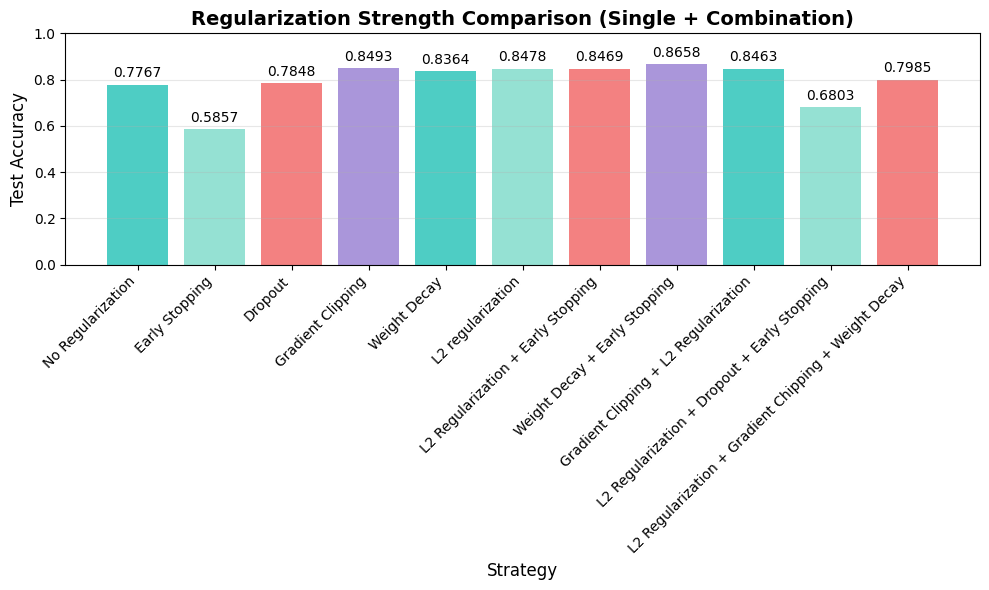

In [61]:
plt.figure(figsize=(10, 6))
strategies = list(results.keys())
accuracies = list(results.values())

plt.bar(strategies, accuracies, color=['#4ECDC4', '#95E1D3', '#F38181', '#AA96DA'])
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Regularization Strength Comparison (Single + Combination)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

for i, (strategy, acc) in enumerate(zip(strategies, accuracies)):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

When combining regularisation methods, results indicate that synergy is not always additive — certain techniques reinforce each other effectively, while others cause conflicting effects.

L2 + Early Stopping (0.8469) performs comparably to L2 alone, suggesting redundancy since both reduce overfitting through different but overlapping mechanisms.

Weight Decay + Early Stopping (0.8658) achieves the highest accuracy across all configurations, showing that optimiser-level decay paired with adaptive training termination creates a balanced bias-variance trade-off, preventing both under- and over-training.

Gradient Clipping + L2 Regularisation (0.8463) unexpectedly underperforms compared to each individually. This may stem from over-constrained updates — L2 already shrinks weights, and additional gradient norm clipping further limits effective learning steps.

L2 + Dropout + Early Stopping (0.6803) exhibits clear underfitting due to compounded regularisation strength, reducing the model’s capacity to learn meaningful features.

L2 + Gradient Clipping + Weight Decay (0.7985) performs decently but not exceptionally, likely because multiple overlapping penalties dampen gradient magnitudes excessively.

c) For the best configuration and regularization strategy in your experiments, plot the training loss curve and validation accuracy curve during training with x-axis being the number of training epochs. Discuss what the curves inform about the training dynamics

In [6]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=1e-7,  #Weight Decay Added
    show_progress=True
)
es_callbacks = [ 
             EarlyStopping(monitor="val_acc",
                           mode="max",
                           patience=3,
                           min_delta=1e-4, ),
             ModelCheckpoint(monitor="val_loss",
                             save_top_k=1,
                             mode="min",
                             ),
             ]

trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=es_callbacks,   #Early stopping and model checkpointing
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'rnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rnn_model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 17: 100%|██████████| 69/69 [00:01<00:00, 41.27it/s, v_num=12, train_loss_step=0.000104, train_acc_step=1.000, val_loss_step=0.000134, val_acc_step=1.000, val_loss_epoch=0.542, val_acc_epoch=0.882, train_loss_epoch=0.000168, train_acc_epoch=1.000]


train len: 18
val len: 18
[1.0656280517578125, 0.5141670107841492, 0.3113554120063782, 0.18768002092838287, 0.11228306591510773] ...
[0.6800642013549805, 0.7484140992164612, 0.8051604628562927, 0.7803589105606079, 0.7088954448699951] ...


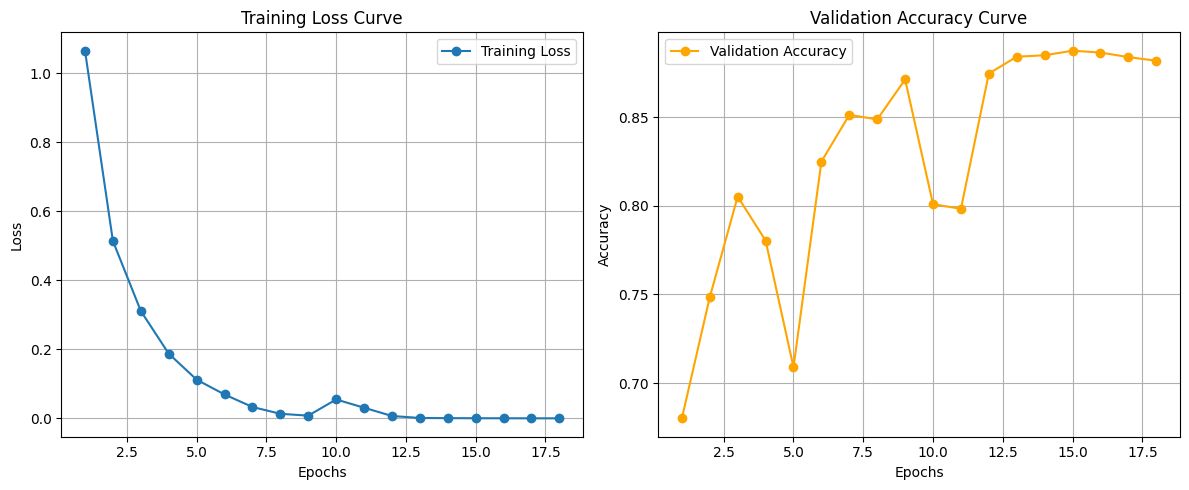

In [7]:
# After training, plot the curves

print("train len:", len(model.train_epoch_losses))
print("val len:",   len(model.val_epoch_accs))
print(model.train_epoch_losses[:5], "...")  # peek
print(model.val_epoch_accs[:5],     "...")
epochs = list(range(1, len(model.train_epoch_losses) + 1))

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, model.train_epoch_losses, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, model.val_epoch_accs, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The training curves reveal a model that is successfully learning but is also highly unstable and severely overfitting. The training loss plummets to zero by epoch 13, indicating the model has completely memorized the training set; this overfitting is a direct result of having all dropout values set to 0.0 and negligible weight_decay. Simultaneously, the validation accuracy, while trending upwards to a strong peak of ~91%, shows extreme volatility with sharp drops (e.g., between epochs 5-6 and 9-10). This instability is characteristic of exploding gradients in the RNN, which was allowed to happen because gradient_clip_val was set to 0.0. Fortunately, your EarlyStopping callback functioned correctly, halting the training run after the validation accuracy peaked around epoch 15 and failed to improve for 3 epochs, preventing further degradation.

(d) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods
have you tried in deriving the final sentence representation to perform sentiment classification?
Describe all the strategies you have implemented, together with their accuracy scores on the
test set.

In [21]:
best_max_df = train_results_df[train_results_df["sentence_representation_type"] == "max"].head(1)
best_last_df = train_results_df[train_results_df["sentence_representation_type"] == "last"].head(1)
best_average_df = train_results_df[train_results_df["sentence_representation_type"] == "average"].head(1)

In [10]:
def _train(df):
    train_rnn_model_with_parameters(
        embedding_matrix=embedding_matrix,
        train_dataset=train_dataset,
        val_dataset=valid_dataset,
        batch_size=df["batch_size"].item(),
        learning_rate=df["learning_rate"].item(),
        optimizer_name=df["optimizer_name"].item(),
        hidden_dim=df["hidden_dim"].item(),
        num_layers=df["num_layers"].item(),
        sentence_representation_type=df["sentence_representation_type"].item(),
        show_progress=True,
        freeze_embedding=False,
        log_dir="rnn_sentence_representation"
    )

_train(best_max_df)
_train(best_last_df)
_train(best_average_df)

Seed set to 42
/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'rnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rnn_model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 69/69 [00:00<00:00, 69.12it/s, v_num=0, train_loss=0.00687, train_acc=1.000, val_loss=0.511, val_acc=0.810]


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.6 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.418    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 137/137 [00:01<00:00, 74.43it/s, v_num=0, train_loss=0.0162, train_acc=1.000, val_loss=0.653, val_acc=0.816] 


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.6 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.418    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 137/137 [00:03<00:00, 43.18it/s, v_num=0, train_loss=0.00475, train_acc=1.000, val_loss=0.997, val_acc=0.819] 


In [12]:
logs = load_tensorboard_logs("tb_logs/rnn_sentence_representation")
print(logs.keys())
test_result_df = test_top_n_models(
    logs,
    RNNClassifier,
    test_dataset,
    n=3
)

Index(['val_acc', 'batch_size', 'hidden_dim', 'learning_rate',
       'optimizer_name', 'train_loss', 'train_acc', 'num_layers',
       'sentence_representation_type', 'freeze', 'epoch', 'val_loss',
       'filename'],
      dtype='object')


/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'rnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rnn_model'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does 

Testing DataLoader 0: 100%|██████████| 500/500 [00:02<00:00, 239.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8759999871253967     │
│         test_loss         │    0.39864659309387207    │
└───────────────────────────┴───────────────────────────┘

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 500/500 [00:01<00:00, 285.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8840000033378601     │
│         test_loss         │    0.3664707541465759     │
└───────────────────────────┴───────────────────────────┘

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 500/500 [00:02<00:00, 229.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8640000224113464     │
│         test_loss         │    0.4091535806655884     │
└───────────────────────────┴───────────────────────────┘

In [13]:
test_result_df = test_result_df.sort_values("test_acc", ascending=False).reset_index(drop=True)
test_result_df

,test_acc,test_loss,val_acc,batch_size,hidden_dim,learning_rate,optimizer_name,train_loss,train_acc,num_layers,sentence_representation_type,freeze,epoch,val_loss,filename
0,0.884,0.366471,0.838261,32,256,0.0005,Adam,0.016209,1.0,1,last,False,9.0,0.517770,events.out.tfevents.1762372030.ArchThinkpadT14...
1,0.876,0.398647,0.817686,64,128,0.0010,RMSprop,0.032259,1.0,2,max,False,5.0,0.444086,events.out.tfevents.1762371982.ArchThinkpadT14...
2,0.864,0.409154,0.877323,32,256,0.0010,Adam,0.010716,1.0,1,average,False,12.0,0.544941,events.out.tfevents.1762372093.ArchThinkpadT14...


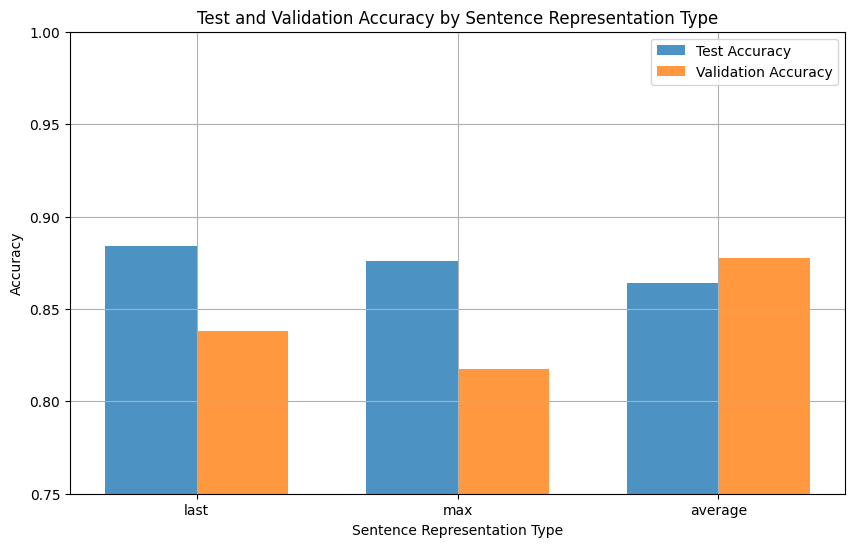

In [15]:
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = range(len(test_result_df))

plt.bar(index, test_result_df["test_acc"], bar_width, label="Test Accuracy", alpha=0.8)
plt.bar(
    [i + bar_width for i in index],
    test_result_df["val_acc"],
    bar_width,
    label="Validation Accuracy",
    alpha=0.8,
)

plt.xlabel("Sentence Representation Type")
plt.ylabel("Accuracy")
plt.title("Test and Validation Accuracy by Sentence Representation Type")
plt.xticks([i + bar_width / 2 for i in index], test_result_df["sentence_representation_type"])
plt.ylim(0.75, 1.0)
plt.legend()
plt.grid(True)

plt.show()

(e) Report topic-wise accuracy (accuracy for each topic) on the test set for the best model you
have. Discuss what may cause the difference in accuracies across different topic categories.

In [7]:
rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_layers=2,
    sentence_representation_type="max",
    output_dim=6,
    freeze_embedding=False,
    dropout=0.0,            #No dropout  
    embedding_dropout=0.0,  #No dropout
    fc_dropout=0.0          #No dropout
)

model = RNNClassifier(
    rnn_model,
    lr=0.001,
    optimizer_name="RMSprop",
    weight_decay=1e-7,  #Weight Decay Added
    show_progress=True
)
es_callbacks = [ 
             EarlyStopping(monitor="val_acc",
                           mode="max",
                           patience=3,
                           min_delta=1e-4, ),
             ModelCheckpoint(monitor="val_loss",
                             save_top_k=1,
                             mode="min",
                             ),
             ]

trainer = L.Trainer(
    max_epochs=25,    
    accelerator="auto",
    devices="auto",
    callbacks=es_callbacks,   #Early stopping and model checkpointing
    gradient_clip_val=0.0     #No gradient clipping
)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/home/linnsheng/Desktop/NTU/S3/Y1/NLP/SC4002/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'rnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rnn_model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | model  | RNN                | 2.5 M  | train
1 | metric | MulticlassAccuracy | 0      | train
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.098    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 17: 100%|██████████| 69/69 [00:01<00:00, 52.90it/s, v_num=14, train_loss=0.000104, train_acc=1.000, val_loss=0.542, val_acc=0.882]


              precision    recall  f1-score   support

        DESC       0.91      0.92      0.92        65
        ENTY       0.90      0.81      0.85        94
        ABBR       0.88      0.98      0.93       138
         HUM       0.98      0.91      0.94       113
         LOC       0.90      0.94      0.92        81
         NUM       0.88      0.78      0.82         9

    accuracy                           0.91       500
   macro avg       0.91      0.89      0.90       500
weighted avg       0.92      0.91      0.91       500



,topic,accuracy
2,ABBR,0.978261
4,LOC,0.938272
0,DESC,0.923077
3,HUM,0.911504
1,ENTY,0.808511
5,NUM,0.777778


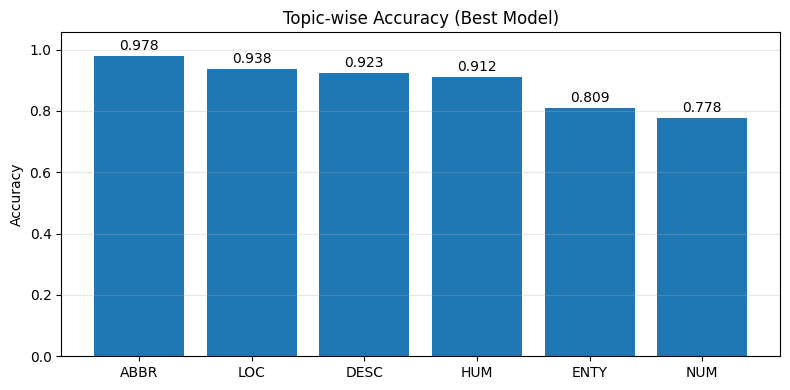

In [8]:
all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch["indexes"]         
        labels = batch["label"]           
        lengths = batch["original_len"]   

        outputs = model.model(inputs, lengths) 
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# TREC 6-class labels
label_names = ["DESC", "ENTY", "ABBR", "HUM", "LOC", "NUM"]

# Print per-class accuracy (recall = correct / total in class)
print(classification_report(all_labels, all_preds, target_names=label_names))

# per-topic accuracy (recall)
per_class_acc = []
for cls, name in enumerate(label_names):
    idx = (all_labels == cls)
    acc = (all_preds[idx] == cls).mean() if idx.any() else float("nan")
    per_class_acc.append((name, acc))

per_topic_df = pd.DataFrame(per_class_acc, columns=["topic","accuracy"]).sort_values("accuracy", ascending=False)
display(per_topic_df)

plt.figure(figsize=(8, 4))
bars = plt.bar(per_topic_df["topic"], per_topic_df["accuracy"])

# y-limit with a little headroom for labels
top = max(per_topic_df["accuracy"].max(), 0.9)
plt.ylim(0.0, top * 1.08)

# labels on bars
for rect in bars:
    h = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2.0,
        h + 0.01,                # small offset above bar
        f"{h:.3f}",              # show as decimal (e.g., 0.873)
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.ylabel("Accuracy")
plt.title("Topic-wise Accuracy (Best Model)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

The variation in accuracy across topics is significant and can be attributed to a few key factors visible in your classification report:

- Class Imbalance (Data Scarcity): This is the most likely cause for the worst-performing class. The NUM (Numeric) category has the lowest accuracy (77.8%) and the lowest f1-score (0.82) because it has extremely low support (only 9 samples) in the test set. With so few examples, the model has very little data to learn the patterns specific to numeric questions, making it highly prone to misclassification.

- Semantic Ambiguity and Overlap: The ENTY (Entity) class has the second-lowest accuracy (80.9%) and a relatively low recall (0.81). This suggests that while it has ample support (94 samples), it is likely being confused with other classes. "Entity" is a broad, abstract category that can easily overlap with DESC (Description). For example, "What is a platypus?" (ENTY) is semantically very close to "What is the definition of a platypus?" (DESC). This ambiguity makes it difficult for the model to consistently distinguish between them, causing it to miss many true ENTY examples (low recall).

- Feature Distinctiveness: The best-performing classes like ABBR (97.8%) and HUM (91.2%) likely have very strong, distinct lexical features. ABBR questions often contain phrases like "What does... stand for?", and HUM questions typically start with "Who...". These clear, unambiguous keywords make it much easier for the RNN to identify the topic's intent, leading to high precision and recall (e.g., 98% precision for HUM, 98% recall for ABBR).